# Summary

This notebook is to visualize results for different simulations produced via TVB and then to validate the data. Namely, I need to check:
* SEEG signals and make sure they are bandpass filtered / high pass filtered
* Z time series and onset/offset times are correctly stored

Then I can resave data

In [1]:
# %pylab nbagg
from tvb.simulator.lab import *
import os.path
from matplotlib import colors, cm
import time
import scipy.signal as sig

import numpy as np
import pandas as pd
import scipy.io

# downloaded library for peak detection in z time series
import peakdetect
from runmainsim import *
import tvbsim

import re
import sys
sys.path.append('/Users/adam2392/Documents/fragility_analysis/')
import fragility.signalprocessing as sp

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
from scipy.signal import butter, lfilter
def butter_bandpass(lowcut, highcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band', analog=False)
    return b, a
def butter_bandpass_filter(data, lowcut, highcut, fs, order=5):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y
def butter_highpass(lowcut, fs, order=5):
    nyq = 0.5 * fs
    low = lowcut / nyq
    b, a = butter(order, low, btype='highpass', analog=False)
    return b, a
def butter_highpass_filter(data, lowcut, fs, order=5):
    b, a = butter_highpass(lowcut, fs, order=order)
    y = scipy.signal.filtfilt(b, a, data)
    return y
def overlap(start1, end1, start2, end2):
    """Does the range (start1, end1) overlap with (start2, end2)?"""
    return (
        start1 <= start2 <= end1 or
        start1 <= end2 <= end1 or
        start2 <= start1 <= end2 or
        start2 <= end1 <= end2
    )

import matplotlib
import matplotlib.pyplot as plt

def getseiztimes(onsettimes, offsettimes):
    minsize = np.min((len(onsettimes),len(offsettimes)))
    
    seizonsets = []
    seizoffsets = []
    idx = 0
    while idx < minsize-1:
        seizonsets.append(onsettimes[idx])
        onsettime = onsettimes[idx]
        offsettime = offsettimes[idx]
        next_onset = onsettimes[idx+1]
        next_offset = offsettimes[idx+1] 

        idx+=1
        # for idx in xrange(len(onsettimes)):
        while overlap(onsettime, offsettime, next_onset,next_offset):
            if idx >= len(onsettimes) or idx >= len(offsettimes):
                break
            next_onset = onsettimes[idx]
            next_offset = offsettimes[idx]
            idx+=1

        seizoffsets.append(offsettimes[idx-1])

    return seizonsets, seizoffsets

def getseiztimes_v2(onsettimes, offsettimes):
    minsize = np.min((len(onsettimes),len(offsettimes)))
    seizonsets = []
    seizoffsets = []
    
    # perform some checks
    if minsize == 0:
        print "no full onset/offset available!"
        return 0
    
    idx = 0
    # to store the ones we are checking rn
    _onset = onsettimes[idx]
    _offset = offsettimes[idx]
    seizonsets.append(_onset)
    
    # start loop after the first onset/offset pair
    for i in range(1,minsize):        
        # to store the previoius values
        _nextonset = onsettimes[i]
        _nextoffset = offsettimes[i]
        
        # check this range and add the offset if it was a full seizure
        # before the next seizure
        if _nextonset < _offset:
            _offset = _nextoffset
        else:
            seizoffsets.append(_offset)
            idx = i
            # to store the ones we are checking rn
            _onset = onsettimes[idx]
            _offset = offsettimes[idx]
            seizonsets.append(_onset)
    if len(seizonsets) != len(seizoffsets):
        seizonsets = seizonsets[0:len(seizoffsets)]
    return seizonsets, seizoffsets
            
def getonsetsoffsets(zts, ezindices, pzindices, delta=0.2/8):
    # create lambda function for checking the indices
    check = lambda indices: isinstance(indices,np.ndarray) and len(indices)>=1
    
    onsettimes=np.array([])
    offsettimes=np.array([])
    if check(ezindices):
        print "checked ezindices"
        for ezindex in ezindices:
            _onsettimes, _offsettimes = postprocessor.findonsetoffset(zts[ezindex, :].squeeze(), 
                                                                    delta=delta)
            onsettimes = np.append(onsettimes, np.asarray(_onsettimes))
            offsettimes = np.append(offsettimes, np.asarray(_offsettimes))

    if check(pzindices):
        print "checked pzindices"
        for pzindex in pzindices:
            _onsettimes, _offsettimes = postprocessor.findonsetoffset(zts[pzindex, :].squeeze(), 
                                                                    delta=delta)
            onsettimes = np.append(onsettimes, np.asarray(_onsettimes))
            offsettimes = np.append(offsettimes, np.asarray(_offsettimes))

    # first sort onsettimes and offsettimes
    onsettimes.sort()
    offsettimes.sort()
    
    return onsettimes, offsettimes

In [3]:
# patients = ['id001_ac', 'id002_cj', 'id014_rb']
nez = 3
npz = 1
samplerate = 1000.

# TVB Sim directory & results to save directory
tvbsimdir = os.path.join('/Users/adam2392/Documents/pydata/tvbforwardsim/',
                         'nez'+str(nez)+'_npz'+str(npz))

alldatafiles = []
for root, dirs, files in os.walk(tvbsimdir):
    for file in files:
        if file.endswith(".npz"):
            alldatafiles.append(os.path.join(root, file))
            
### Set the font dictionaries (for plot title and axis titles)
title_font = {'fontname':'Arial', 'size':'30', 'color':'black', 'weight':'normal',
          'verticalalignment':'bottom'} # Bottom vertical alignment for more space
axis_font = {'family':'Arial', 'size':'30'}

color_new = ['peru', 'dodgerblue', 'slategrey', 
             'skyblue', 'springgreen', 'fuchsia', 'limegreen', 
             'orangered',  'gold', 'crimson', 'teal', 'blueviolet', 'black', 'cyan', 'lightseagreen',
             'lightpink', 'red', 'indigo', 'mediumorchid', 'mediumspringgreen']

File that is analyzed:  /Users/adam2392/Documents/pydata/tvbforwardsim/nez3_npz1/id002_cj_sim_nez3_npz1.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
[21 61 28]
[16]
checked ezindices
checked pzindices

seizure onsets: [  19039.   20329.   20905.   41351.   99114.  103489.  112909.  165945.
  202621.  203924.  207697.]
seizure offsets: [  52045.   53782.   59823.   74234.  143358.  150075.  151601.  201185.]

actual seizure onsets: [19039.0, 99114.0]
actual seizure offsets: [74234.0, 151601.0]
202621.0 151601.0
(84, 158000)


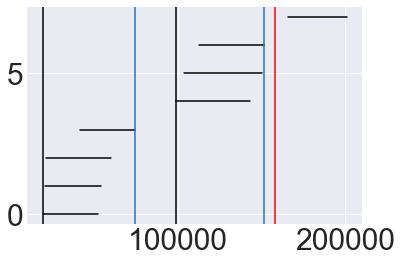

File that is analyzed:  /Users/adam2392/Documents/pydata/tvbforwardsim/nez3_npz1/id014_rb_sim_nez3_npz1.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
[44 38 27]
[83]
checked ezindices
checked pzindices

seizure onsets: [  17904.   18377.   18484.   37680.   98277.  116350.  117194.  161156.
  188161.  213951.  219613.]
seizure offsets: [  50854.   58966.   60828.   70474.  136114.  158405.  159791.  197741.
  232544.]

actual seizure onsets: [17904.0, 98277.0]
actual seizure offsets: [70474.0, 159791.0]
213951.0 159791.0
(84, 160000)


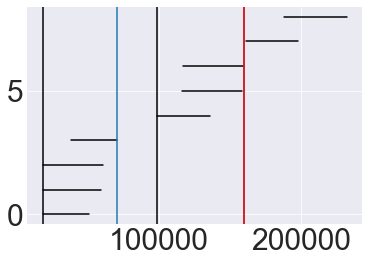

File that is analyzed:  /Users/adam2392/Documents/pydata/tvbforwardsim/nez3_npz1/id001_ac_sim_nez3_npz1.npz
['metadata', 'zts', 'seegts', 'epits', 'times']
['patient', 'pz', 'onsettimes', 'seeg_xyz', 'x0ez', 'regions_centers', 'regions', 'seeg_contacts', 'offsettimes', 'x0pz', 'ez', 'pzindices', 'x0norm', 'ezindices']
[22 78 16]
[82]
checked ezindices
checked pzindices

seizure onsets: [  17321.   17572.   21770.   42417.  109268.  116523.  116895.  155902.
  197782.  202072.  222309.]
seizure offsets: [  55695.   59946.   61573.   71898.  148265.  149687.  162480.  194049.
  232647.  234732.]

actual seizure onsets: [17321.0, 109268.0]
actual seizure offsets: [71898.0, 194049.0]
222309.0 194049.0
(84, 195000)


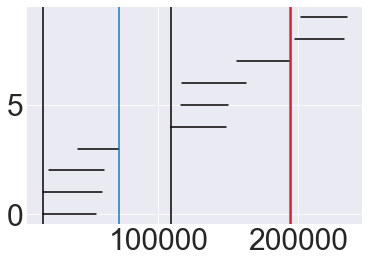

In [118]:
for idx,patfile in enumerate(alldatafiles):
    # load in data
    simdata = np.load(patfile)
    metadata = simdata['metadata'].item()
    seegts = simdata['seegts']
    times = simdata['times']
    zts = simdata['zts']
    epits = simdata['epits']

    # instantiate the postprocessor
    postprocessor = tvbsim.util.PostProcess(epits, seegts, times)

    print "File that is analyzed: ", patfile
    print simdata.keys()
    print metadata.keys()
    
    ezindices = metadata['ezindices']
    pzindices = metadata['pzindices']
    print ezindices
    print pzindices

    # get the onsettimes and offsettimes for ez/pz indices
    onsettimes, offsettimes = getonsetsoffsets(zts, np.array(ezindices), np.array(pzindices))
    
    print "\nseizure onsets:", onsettimes
    print "seizure offsets:", offsettimes
    minsize = np.min((len(onsettimes),len(offsettimes)))
 
    # get the actual seizure times and offsets
    seizonsets, seizoffsets = getseiztimes_v2(onsettimes, offsettimes)
            
    print "\nactual seizure onsets:", seizonsets
    print "actual seizure offsets:", seizoffsets
    
    fig = plt.figure()
    for idx in xrange(minsize):
        plt.plot([onsettimes[idx], offsettimes[idx]], [np.r_[idx], np.r_[idx]], 'k-')

    for idx in xrange(len(seizonsets)):
        plt.axvline(seizonsets[idx], color='black')
        plt.axvline(seizoffsets[idx])

    cutoff = None
    if len(onsettimes) > len(offsettimes):
        nextindex = np.where(onsettimes > seizoffsets[-1])[0][0]
        # create a cutoff for the entire simulated data
        cutoff = np.mean([onsettimes[nextindex], seizoffsets[-1]])
        
        print onsettimes[minsize], seizoffsets[-1]
        
        # floor to the nearest sample rate
        cutoff = int(math.floor(cutoff / float(samplerate)) * float(samplerate))
        
        plt.axvline(cutoff, color='red')
        epits = epits[:,0:cutoff]
        seegts = seegts[:, 0:cutoff]
        zts = zts[:, 0:cutoff]
        times = times[0:cutoff]
        
        print epits.shape
        
    plt.show()

    # Save files
    metadata['onsettimes'] = seizonsets
    metadata['offsettimes'] = seizoffsets

    # save tseries
    np.savez_compressed(patfile, epits=epits, seegts=seegts, \
             times=times, zts=zts, metadata=metadata)

ezreion is:  ['ctx-lh-middletemporal']
pzregion is:  ['ctx-lh-precuneus']
x0 values are (ez, pz, norm):  -1.7 -2.0 -2.4
time series shape is:  (84, 240000)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
here: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74
 75 76 77 78 79 80 81 82 83]
index 4 is out of bounds for axis 0 with size 4
Was trying to plot 

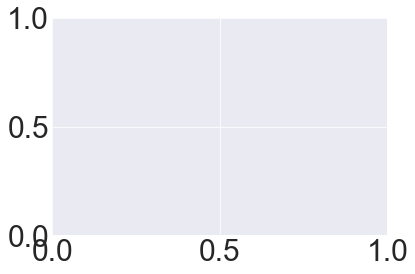

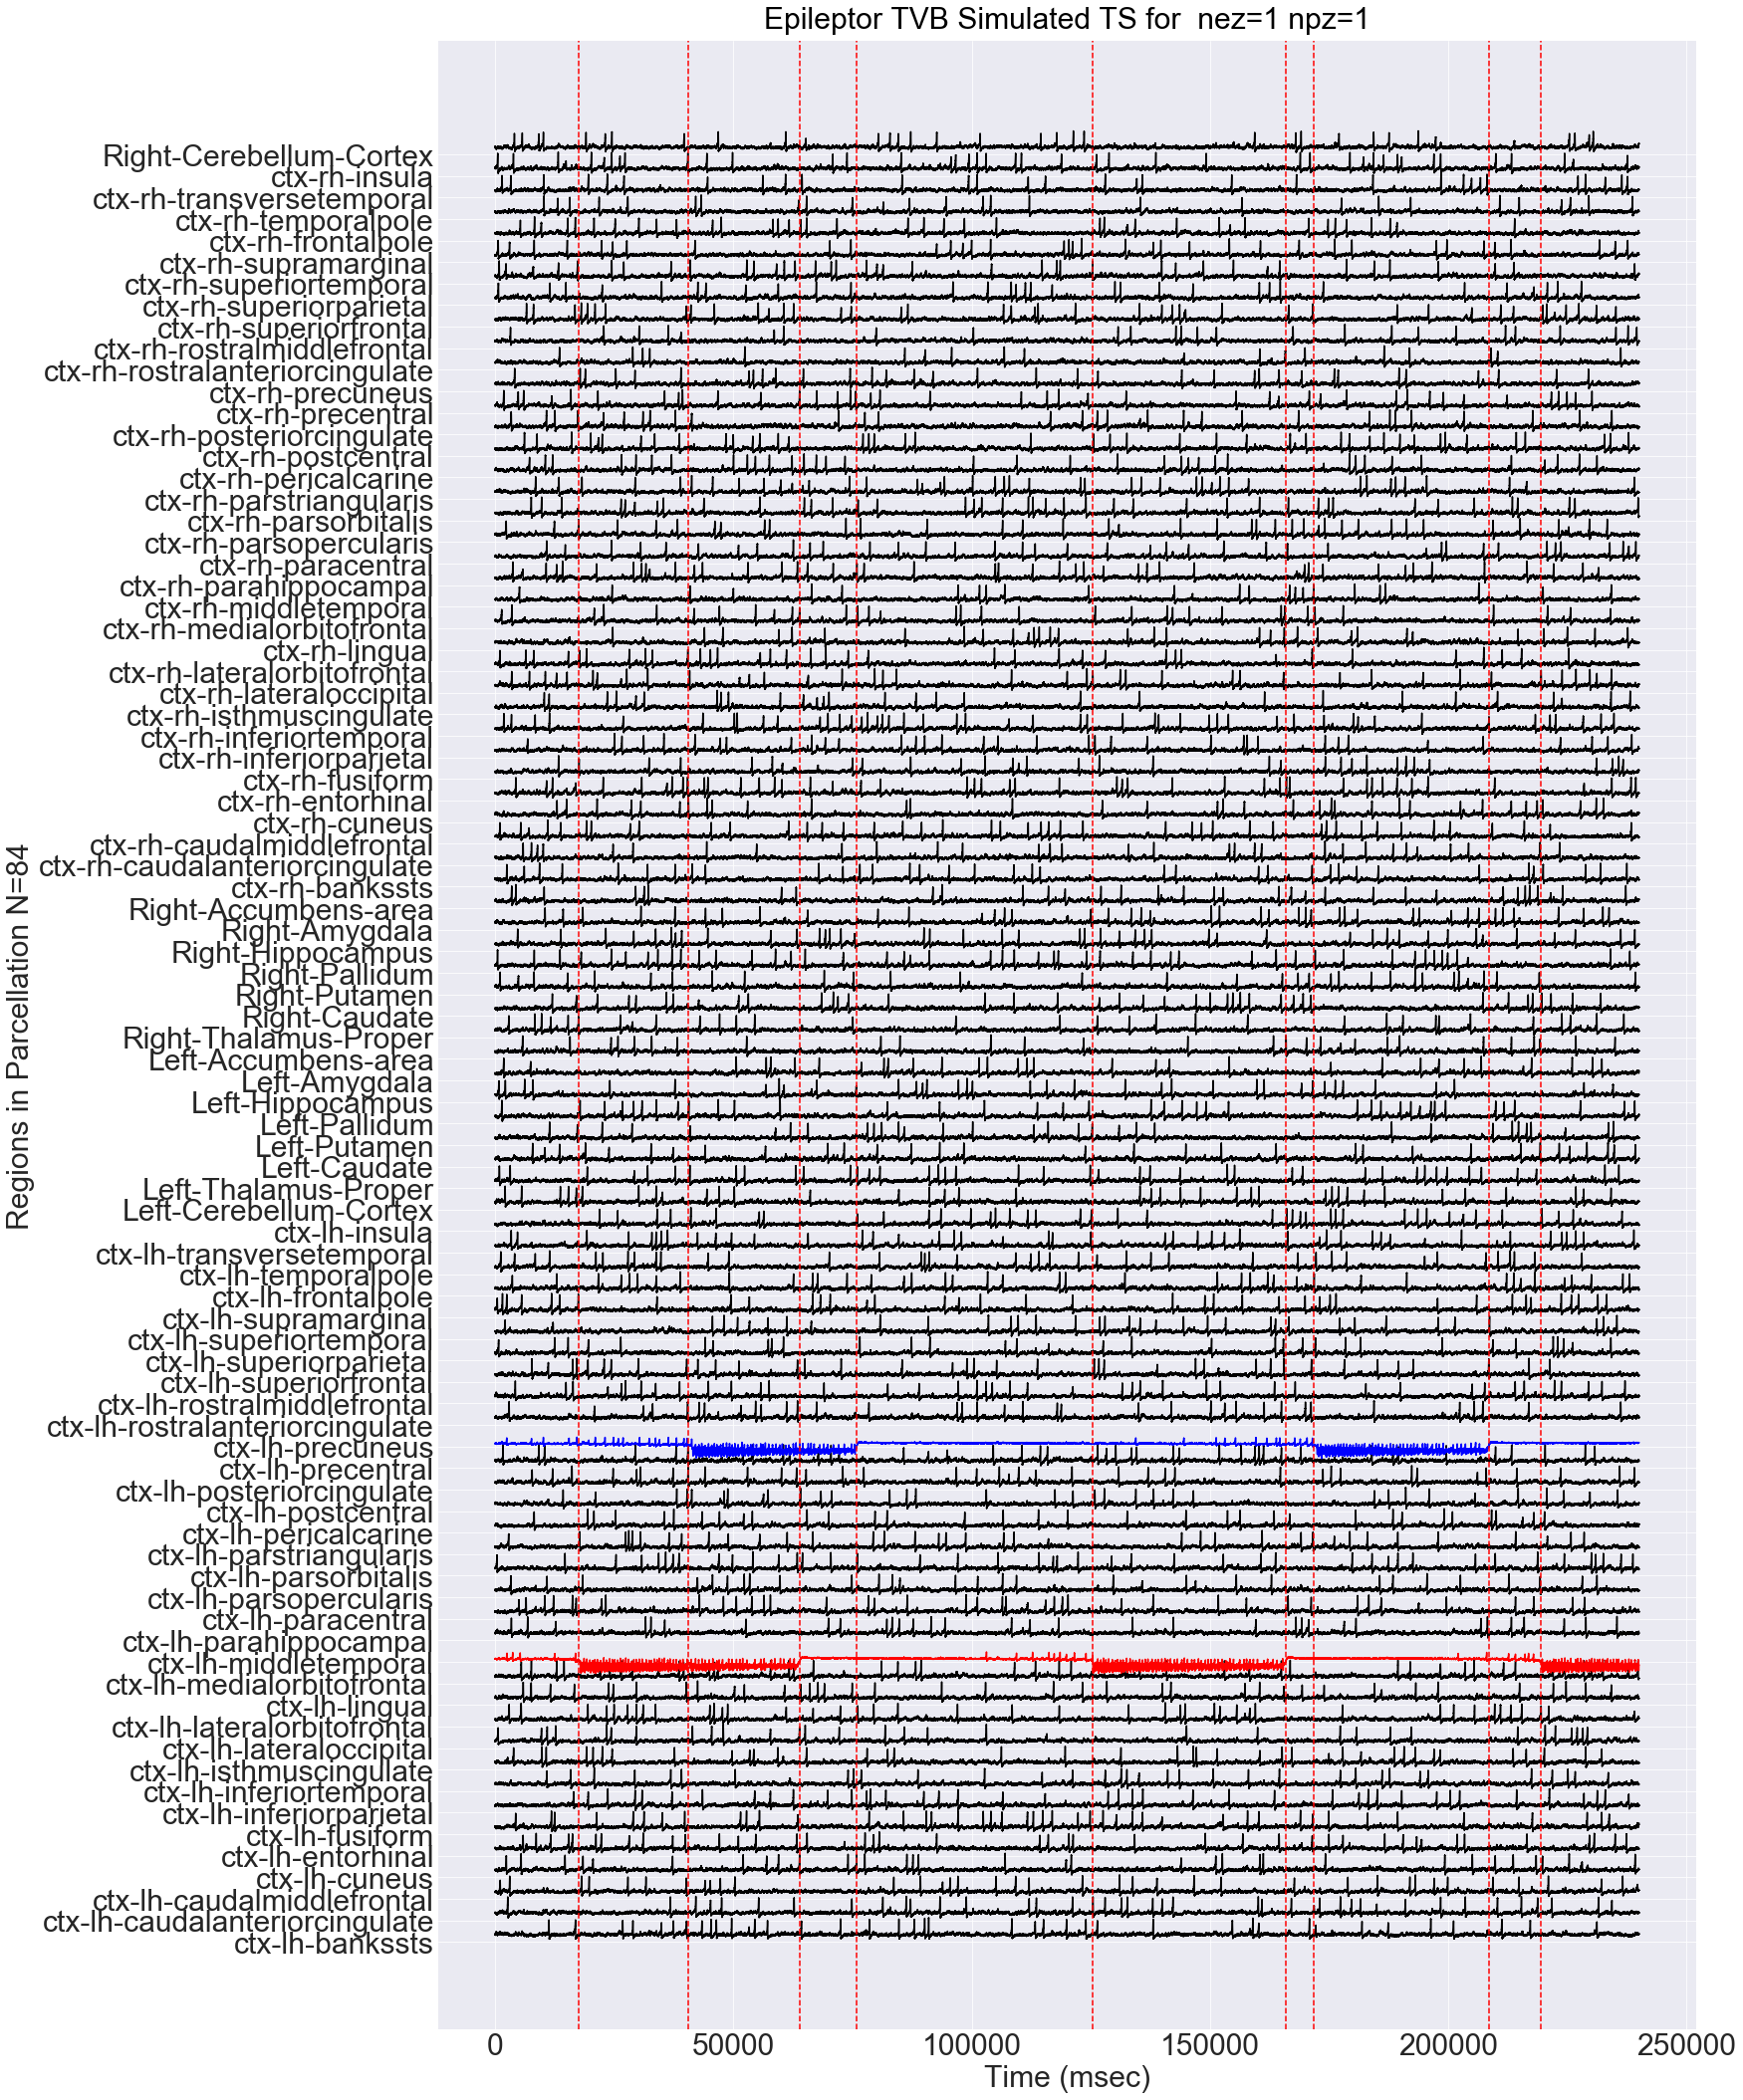

In [110]:
rawplotter = tvbsim.visualize.RawPlotter(axis_font, title_font, color_new)
rawplotter.initializefig(figsize=(25,30))
epifig = rawplotter.plotepileptorts(epits, times, metadata, onsettimes, offsettimes, plotsubset=False)

In [5]:
data = np.load('/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist3/id014_rb_sim_nez1_npz1.npz')
metadata = data['metadata'].item()
zts = data['zts']
seegts = data['seegts']
epits = data['epits']
times = data['times']


print(data.keys())

['metadata', 'zts', 'seegts', 'epits', 'times']


In [6]:
np.savez_compressed('/Volumes/ADAM LI/pydata/tvbforwardsim/varydistance/nez1_npz1_dist3/id014_rb_sim_nez1_npz1.npz',
                   metadata=metadata, zts=zts, seegts=seegts, epits=epits, times=times)